In [ ]:
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt
from tqdm import tqdm

root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

from scripts.logger import LoggerManager
from scripts.analysis.model_analysis import perform_model_analysis

from CICIDS2017.dataset import CICIDS2017
from UNSWNB15.dataset import UNSWNB15

from scripts.models.pytorch.MLP import NetworkIntrusionMLP
from scripts.models.pytorch.CNN import NetworkIntrustionCNN
from scripts.models.pytorch.LSTM import NetworkIntrusionLSTM

from scripts.models.pytorch.train import train
from scripts.models.pytorch.visualization import display_loss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lm = LoggerManager(log_dir=f"{root_dir}/logs", log_name="TDM")
logger = lm.get_logger()
title = lm.get_title()
logger.info(f"Logger initialized for '{title}'")

c:\Users\valen\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-23 13:08:02,578 - INFO - Logger initialized for 'TDM_20251123_130802'


In [ ]:
logger = LoggerManager(log_name="rf_notebook").get_logger()
logger.info("Starting Random Forest training notebook")

dataset = UNSWNB15(dataset_size="small", logger=logger)

dataset = dataset.optimize_memory()
before_encode_cols = dataset.X.columns.tolist()
dataset = dataset.encode()
encoded_cols = dataset.X.columns.tolist()

dataset = dataset.scale().subset(size=100000, multi_class=True)

2025-11-23 13:08:49,086 - INFO - Starting Random Forest training notebook
2025-11-23 13:08:49,090 - INFO - Downloading dataset: mrwellsdavid/unsw-nb15
2025-11-23 13:08:57,833 - INFO - Loaded UNSW-NB15_1.csv with shape: (700000, 46)
2025-11-23 13:08:57,847 - INFO - DataFrame shape: (700000, 46)
2025-11-23 13:08:57,848 - INFO - Initial dimensions: 700,000 rows x 46 columns = 32,200,000 cells
2025-11-23 13:09:02,560 - INFO - ============================================================
2025-11-23 13:09:02,561 - INFO - Preprocessing completed successfully
2025-11-23 13:09:02,563 - INFO - Final dimensions: 640,658 rows x 46 columns
2025-11-23 13:09:02,564 - INFO - Total rows removed: 59,342 (8.48%)
2025-11-23 13:09:02,566 - INFO - data retention rate: 91.52%
2025-11-23 13:09:02,566 - INFO - ============================================================
2025-11-23 13:09:02,793 - INFO - Optimizing memory usage of the dataset...
2025-11-23 13:09:02,823 - INFO - Initial memory usage: 229.73 MB
202

In [4]:
X_train, X_test, y_train, y_test = dataset.split(test_size=0.2, apply_smote=True)
print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

2025-11-23 13:09:09,491 - INFO - Splitting dataset into training and testing sets...
2025-11-23 13:09:09,510 - INFO - Class distribution before SMOTE:
2025-11-23 13:09:13,217 - INFO - Applied SMOTE to balance the training set.
2025-11-23 13:09:13,219 - INFO - Class distribution after SMOTE:
2025-11-23 13:09:13,220 - INFO -   Class 0: 8039 samples
2025-11-23 13:09:13,221 - INFO -   Class 1: 8039 samples
2025-11-23 13:09:13,222 - INFO -   Class 2: 8039 samples
2025-11-23 13:09:13,222 - INFO -   Class 3: 8039 samples
2025-11-23 13:09:13,223 - INFO -   Class 4: 8039 samples
2025-11-23 13:09:13,223 - INFO -   Class 5: 8039 samples
2025-11-23 13:09:13,224 - INFO -   Class 6: 8039 samples
2025-11-23 13:09:13,225 - INFO -   Class 7: 8039 samples
2025-11-23 13:09:13,227 - INFO -   Class 8: 8039 samples
2025-11-23 13:09:13,229 - INFO -   Class 9: 8039 samples


Train set shape: (80390, 45)
Test set shape: (4856, 45)


In [6]:
from scripts.models.random_forest.random_forest import train_random_forest
# Train Random Forest using standalone function and plot CV scores
logger.info("Training Random Forest with cross-validation using train_random_forest...")
rf_model, cv_scores = train_random_forest(
    X_train,
    y_train,
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=0,
    cv=5,
    class_weight=None,
    logger=None
)
if cv_scores!= None:
    print("\n" + "="*50)
    print("CROSS-VALIDATION RESULTS")
    print("="*50)
    print(f"CV Scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    # Plot CV scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cv_scores)+1), cv_scores, marker='o', markersize=10, linewidth=2, color='green')
    plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', 
                label=f'Mean: {cv_scores.mean():.4f}')
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Decision Tree Cross-Validation Scores', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

2025-11-23 13:09:35,919 - INFO - Training Random Forest with cross-validation using train_random_forest...


2025-11-23 13:10:07,156 - INFO - Running analysis for scikit-learn model: RandomForest


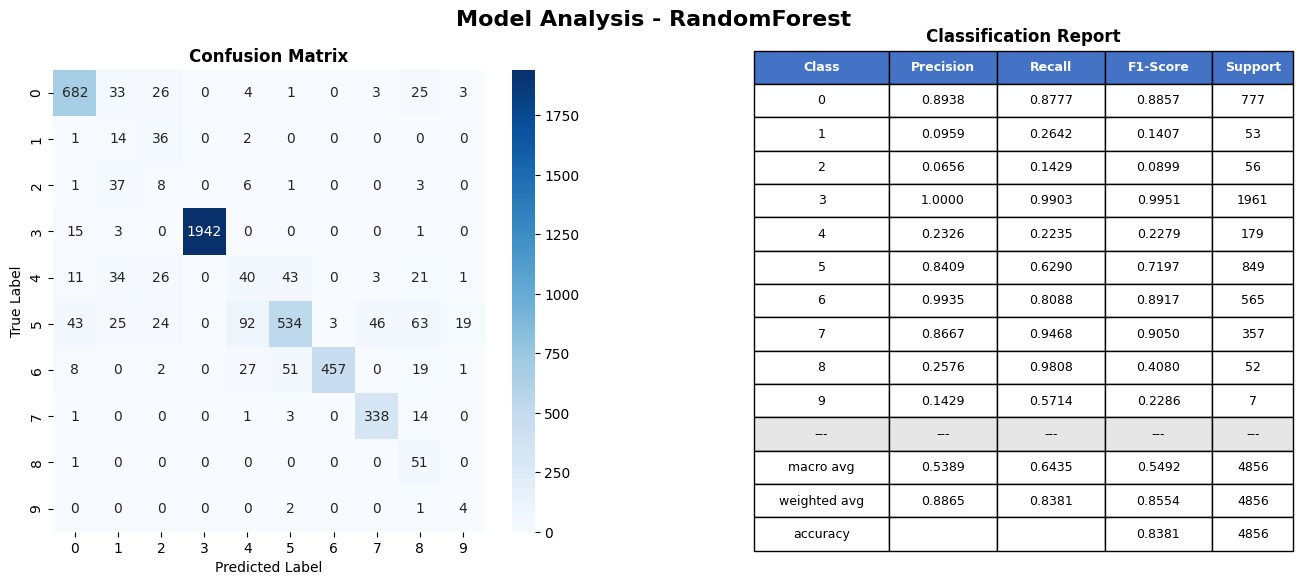

In [7]:
# Evaluate model
cm_rf, cr = perform_model_analysis(
    model=rf_model,
    X_test=X_test,
    y_test=y_test,
    logger=logger,
    model_name="RandomForest",
    dir=os.getcwd(),
    plot=True
)

2025-11-23 13:10:24,663 - INFO - Top 15 most important features:
2025-11-23 13:10:24,663 - INFO - 1. Destination Port: 0.1173
2025-11-23 13:10:24,664 - INFO - 2. Total Length of Fwd Packets: 0.0958
2025-11-23 13:10:24,665 - INFO - 3. sttl: 0.0714
2025-11-23 13:10:24,665 - INFO - 4. Avg Fwd Segment Size: 0.0521
2025-11-23 13:10:24,666 - INFO - 5. ct_state_ttl: 0.0476
2025-11-23 13:10:24,666 - INFO - 6. service: 0.0451
2025-11-23 13:10:24,667 - INFO - 7. ct_srv_dst: 0.0432
2025-11-23 13:10:24,667 - INFO - 8. Total Length of Bwd Packets: 0.0392
2025-11-23 13:10:24,669 - INFO - 9. Avg Bwd Segment Size: 0.0361
2025-11-23 13:10:24,670 - INFO - 10. sport: 0.0344
2025-11-23 13:10:24,671 - INFO - 11. Stime: 0.0327
2025-11-23 13:10:24,672 - INFO - 12. Ltime: 0.0297
2025-11-23 13:10:24,672 - INFO - 13. ct_dst_sport_ltm: 0.0282
2025-11-23 13:10:24,672 - INFO - 14. Bwd Packets/s: 0.0275
2025-11-23 13:10:24,673 - INFO - 15. Total Backward Packets: 0.0233


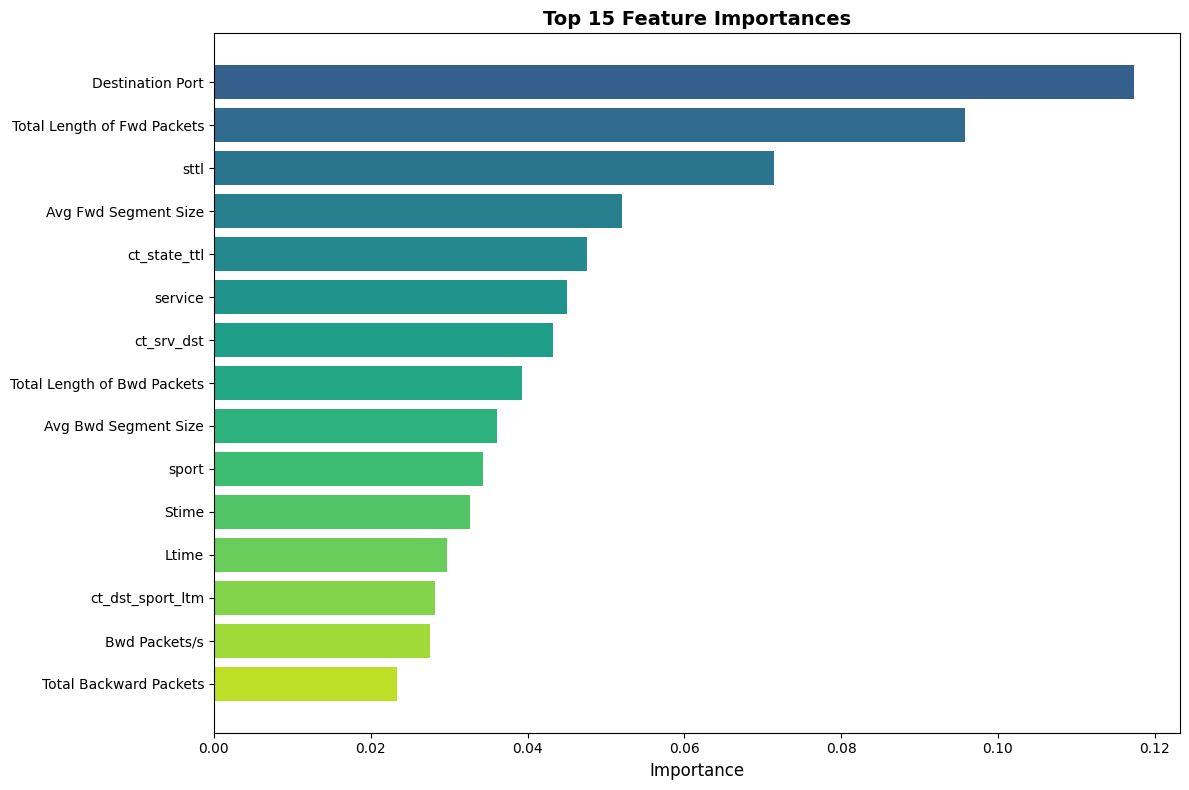

In [8]:
import numpy as np
from scripts.models.model_utils import (
    check_data_leakage,
    get_tree_feature_importance    
)

# Get feature importance
top_features = get_tree_feature_importance(
    rf_model,
    feature_names=list(dataset.data.columns),
    top_n=15,
    logger=logger
)

# Plot feature importance
features, importances = zip(*top_features)

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(features)))
plt.barh(range(len(features)), importances, color=colors)
plt.yticks(range(len(features)), features)
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Part 2: Training of the surrogate

In [11]:
import numpy as np
input_size = dataset.scaled_features.shape[1]
num_classes = np.size(dataset.attack_classes[0])

In [12]:
class NetworkIntrusionMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NetworkIntrusionMLP, self).__init__()

        self.features = nn.Sequential(
            nn.Linear(input_size, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
        )

        self.classifier1 = nn.Sequential(
            nn.Linear(100, num_classes[0]),
        )

        self.classifier2 = nn.Sequential(
            nn.Linear(100 + num_classes[0], 64),
            nn.ReLU(),
            nn.Linear(64, num_classes[1]),
        )

    def forward(self, x):
        features = self.features(x)
        out1 = self.classifier1(features)
        x2 = torch.cat((features, out1), dim=1)
        out2 = self.classifier2(x2)
        return torch.softmax(out2, dim=1)

In [13]:
X_train = torch.tensor(X_train,dtype=torch.float32).to(device)
y_train = torch.tensor(y_train,dtype=torch.long).to(device)
X_test = torch.tensor(X_test,dtype=torch.float32).to(device)
y_test = torch.tensor(y_test,dtype=torch.long).to(device)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_test,y_test)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
model_mlp = NetworkIntrusionMLP(input_size=input_size, num_classes=[2, 10]).to(device)
num_parameters = sum(p.numel() for p in model_mlp.parameters() if p.requires_grad)
print(f"Number of trainable parameters in MLP model: {num_parameters}")
criterion = nn.CrossEntropyLoss()

learning_rate_mlp = 1e-2
num_epochs_mlp = 100

optimizer_mlp = optim.AdamW(model_mlp.parameters(), lr=learning_rate_mlp)
scheduler_mlp = optim.lr_scheduler.ReduceLROnPlateau(optimizer_mlp, mode='min', factor=0.8, patience=10, min_lr=1e-6)

Number of trainable parameters in MLP model: 36744


In [15]:
print(num_classes)
print(torch.unique(y_train))

1
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [16]:
model_mlp, train_losses_mlp, val_losses_mlp = train(
    model=model_mlp,
    optimizer=optimizer_mlp,
    scheduler=scheduler_mlp,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=num_epochs_mlp
)


Loss: 1.7657, Val Loss: 1.6360, LR: 0.008000: 100%|██████████| 100/100 [04:11<00:00,  2.51s/it]


2025-11-23 13:17:08,624 - INFO - Plotting loss curve...


2025-11-23 13:17:11,441 - INFO - Loss curve saved as c:\msys64\home\valen\TDpython\AdversarialNIDS/loss_img/TDM_20251123_130802_MLP_loss.png


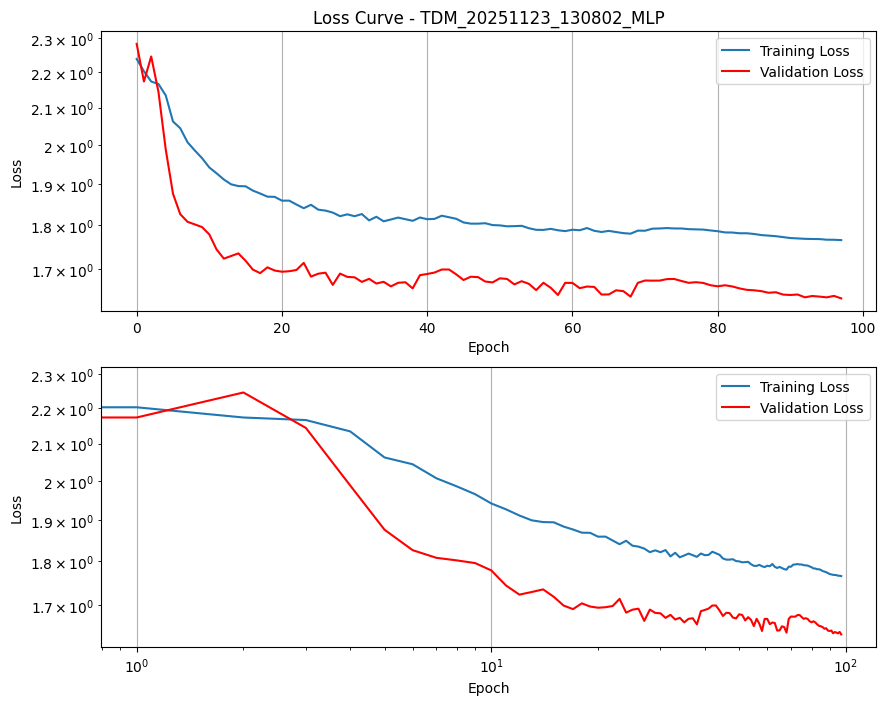

In [17]:
display_loss(
    list_epoch_loss=train_losses_mlp,
    list_val_loss=val_losses_mlp,
    title=f"{title}_MLP",
    dir=root_dir,
    logger=logger,
    epoch_min=2
)

2025-11-23 13:17:17,173 - INFO - Running analysis for PyTorch model: TDM_20251123_130802_MLP on device: cpu


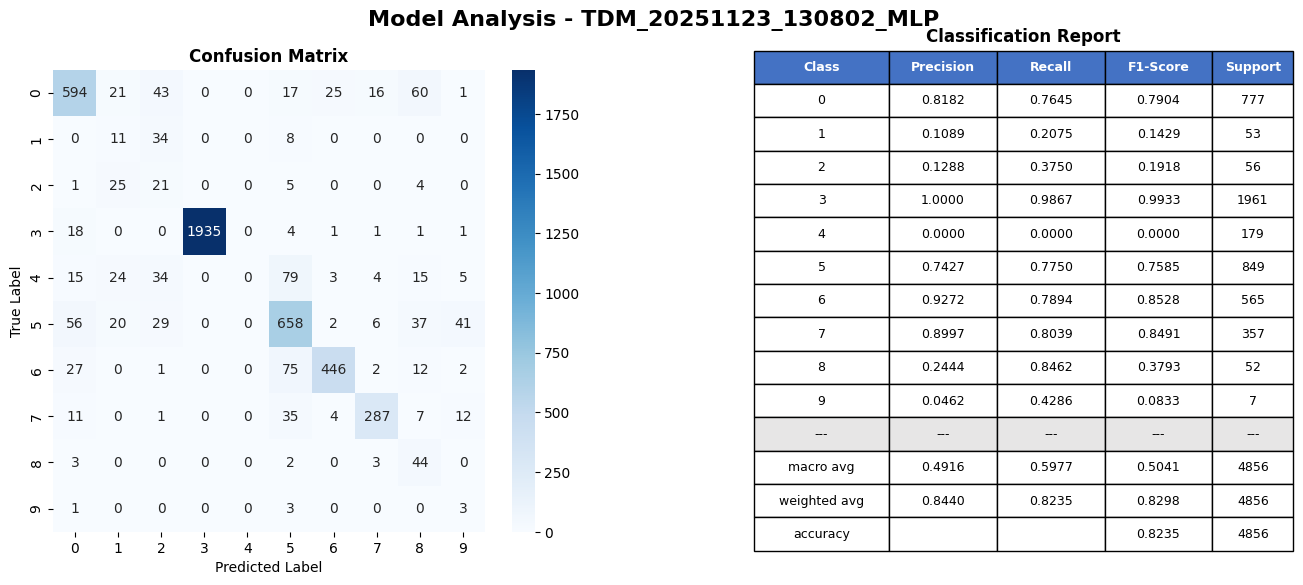

In [18]:
cm_mlp, cr = perform_model_analysis(
    model=model_mlp,
    X_test=X_test,
    y_test=y_test,
    logger=logger,
    model_name=f"{title}_MLP",
    dir=root_dir,
    plot=True,
    device=device
)

3- Attack surrogate

In [19]:
from scripts.Attack.surrogate import attack_fgsm

In [25]:
print(dataset.data)

         sport  Destination Port  proto  state  Flow Duration  \
0          1.0               1.0   79.0    6.0       0.518061   
1          1.0               1.0   79.0    6.0       1.217401   
2      37665.0           60303.0  114.0    5.0       0.395642   
3       2278.0           60303.0  114.0    5.0       0.388297   
4      47705.0           60303.0  114.0    5.0       0.180398   
...        ...               ...    ...    ...            ...   
24273  16005.0           60303.0  114.0    5.0       0.431666   
24274  36614.0           60303.0  114.0    5.0       0.226410   
24275  26906.0           60303.0  114.0    5.0       0.713732   
24276  14486.0           60303.0  114.0    5.0       0.556154   
24277  63720.0           60303.0  114.0    5.0       0.731113   

       Total Length of Fwd Packets  Total Length of Bwd Packets  sttl  dttl  \
0                             1040                            0   254     0   
1                             3024                           

In [ ]:
first_level = dataset.first_level_features()
attacked_features =  list(set(first_level) & set(features))
print(attacked_features)

['sttl', 'service', 'ct_srv_dst', 'ct_dst_sport_ltm', 'sport']


In [ ]:
dico_encoded = {col: encoded_cols.index(col) for col in encoded_cols}
print(dico_encoded)

In [ ]:
indices = [dico_encoded[f] for f in attacked_features]

In [ ]:
target = torch.zeros_like(y_test)
print(X_test)
X_perturb = attack_fgsm(model_mlp,criterion,X_test,target,indices)
for i in range(50):
    X_perturb = attack_fgsm(model_mlp,criterion,X_perturb,target)

tensor([[-0.6867,  1.2626, -0.1724,  ..., -0.3286, -0.2047, -0.5573],
        [-1.6251,  0.5226,  0.6659,  ...,  0.4736, -0.2047, -0.5573],
        [-1.1278,  1.2693, -0.1724,  ..., -0.3286, -0.2047,  0.0712],
        ...,
        [ 0.8037,  1.2626, -0.1724,  ..., -0.3286, -0.2047, -0.5573],
        [ 0.3739,  0.5226,  0.6659,  ...,  0.4736, -0.2047, -0.5573],
        [ 0.6807, -1.5420, -0.1724,  ..., -0.3286, -0.2047, -0.5573]])


TypeError: new(): invalid data type 'str'

4 - MLP Result

2025-11-21 16:16:08,191 - INFO - Running analysis for PyTorch model: TDM_20251121_155851_MLP on device: cpu


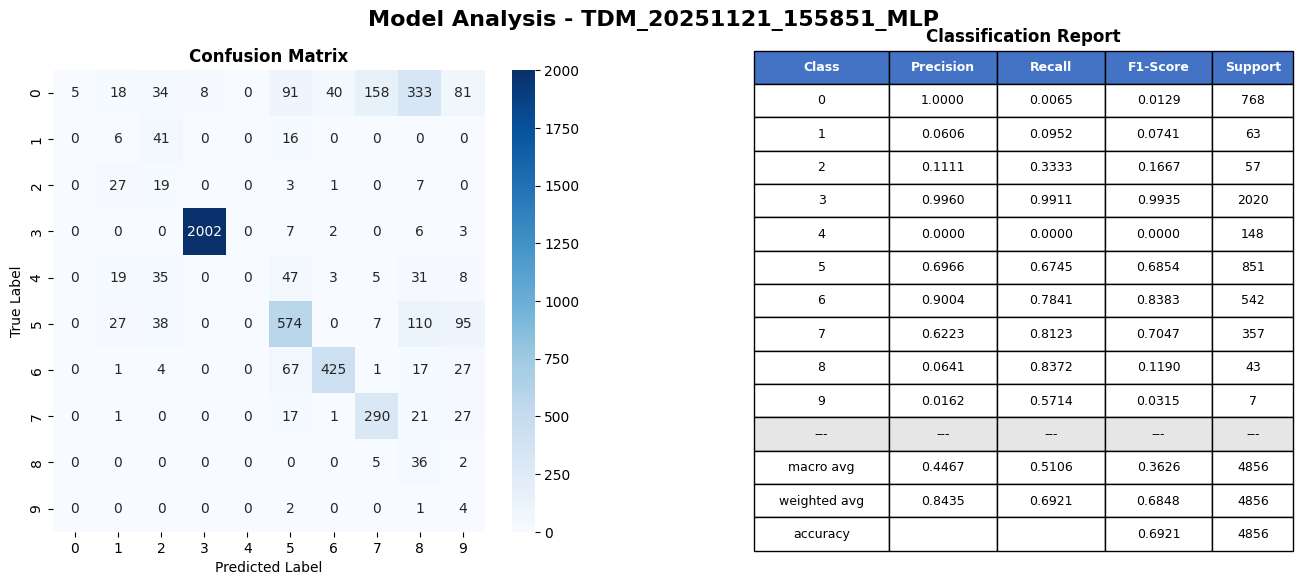

In [ ]:
cm_mlp_perturb, cr = perform_model_analysis(
    model=model_mlp,
    X_test=X_perturb,
    y_test=y_test,
    logger=logger,
    model_name=f"{title}_MLP",
    dir=root_dir,
    plot=True,
    device=device
)

5- RF results

2025-11-21 16:16:28,037 - INFO - Running analysis for scikit-learn model: RandomForest


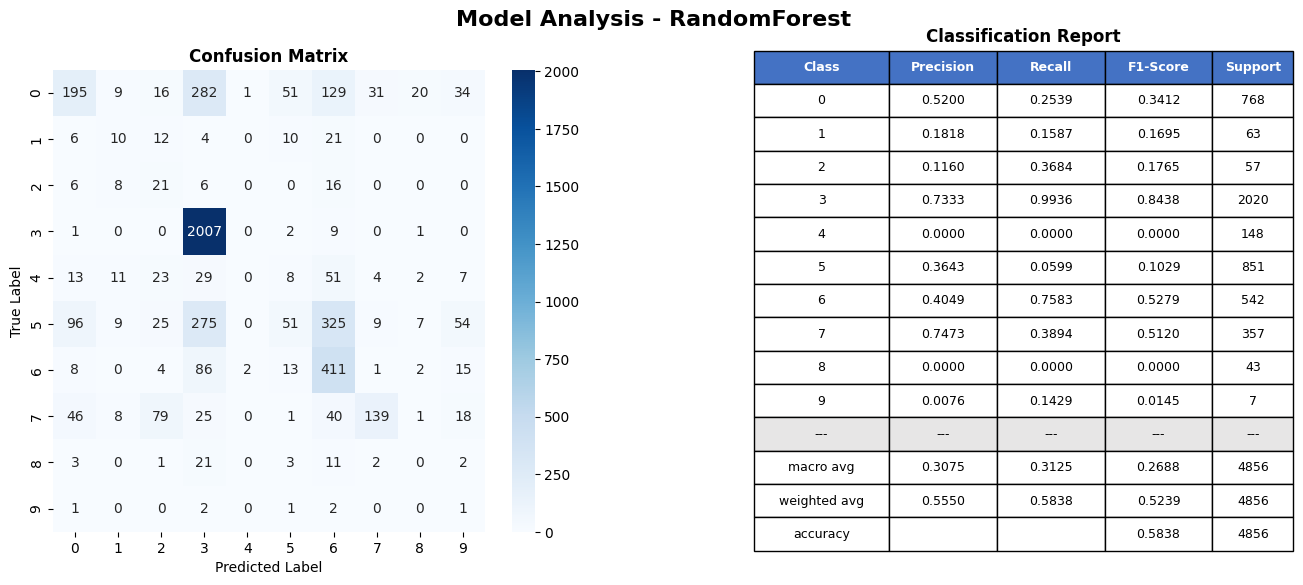

In [ ]:
# Evaluate model
cm_rf_perturb, cr = perform_model_analysis(
    model=rf_model,
    X_test=X_perturb.detach().numpy(),
    y_test=y_test.detach().numpy(),
    logger=logger,
    model_name="RandomForest",
    dir=os.getcwd(),
    plot=True
)

6- Comparision

In [ ]:
comp_rf = cm_rf-cm_rf_perturb
comp_mlp = cm_mlp-cm_mlp_perturb

Text(0.5, 0.98, 'Pertubation Analysis')

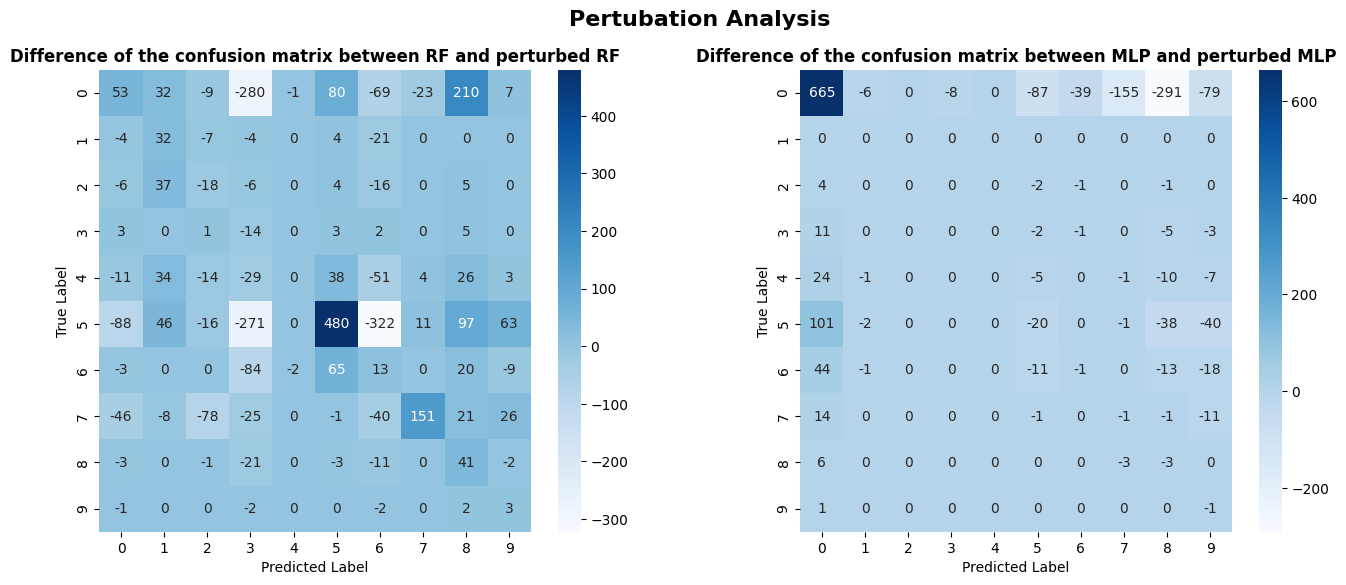

In [ ]:
class_names = [str(i) for i in sorted(np.unique(y_train))]
import seaborn as sns
fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1, 2, wspace=0.3)
        
# Plot confusion matrix (left)
ax_cm1 = fig.add_subplot(gs[0, 0])
sns.heatmap(comp_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax_cm1)
ax_cm1.set_title('Difference of the confusion matrix between RF and perturbed RF', fontsize=12, weight='bold')
ax_cm1.set_xlabel('Predicted Label')
ax_cm1.set_ylabel('True Label')
    
# Plot classification report table (right)
ax_cm2 = fig.add_subplot(gs[0, 1])
sns.heatmap(comp_mlp, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax_cm2)
ax_cm2.set_title('Difference of the confusion matrix between MLP and perturbed MLP', fontsize=12, weight='bold')
ax_cm2.set_xlabel('Predicted Label')
ax_cm2.set_ylabel('True Label')
    
fig.suptitle(f'Pertubation Analysis', fontsize=16, weight='bold')